In [1]:
import numpy as np
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import LSTM, Input, Masking
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers
import keras
import keras.backend as K

In [2]:
from pointer_lstm import PointerDecoder
from sorting_dataset import gen_data, gen_jagged_data

In [3]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [4]:
%reload_ext autoreload
%autoreload 2

np.random.seed(17)

In [5]:
N = 10000
max_seq_len = 5
output_size = max_seq_len + 1

# X, y = gen_data(N, max_seq_len, low=0, high=1000)
X, y = gen_jagged_data(N, max_seq_len, low=1)

# Pad the (jagged) sequences
X = pad_sequences(X, maxlen=max_seq_len + 1, value=-1, padding='post', truncating='post', dtype=np.float32)
y = pad_sequences(y, value=0, padding='post', truncating='post') # maxlen=output_size, 

# Shuffle the sequences
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

X.shape, y.shape

((10000, 6), (10000, 6))

In [6]:
X[:2], y[:2]

(array([[ 0.27586207,  0.63793105,  0.39655173,  1.        , -1.        ,
         -1.        ],
        [ 0.09589041,  0.9726027 ,  1.        ,  0.4520548 , -1.        ,
         -1.        ]], dtype=float32),
 array([[1, 3, 2, 4, 0, 0],
        [1, 4, 2, 3, 0, 0]], dtype=int32))

In [7]:
split = int(0.8 * N)

_X = np.expand_dims(X, axis=2)
# _X = np.repeat(_X, 4, axis=2)

# OHE the labels
_y = to_categorical(y, num_classes=output_size)
# _y = _y[:, :output_size]

X_train = _X[:split]
y_train = _y[:split]

X_test = _X[split:]
y_test = _y[split:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8000, 6, 1), (8000, 6, 6), (2000, 6, 1), (2000, 6, 6))

In [8]:
seq_shape = X_train.shape[1:]
hidden_units = 64
batch_size = 32

inputs = Input(shape=seq_shape, name='input', batch_size=batch_size)
masking = Masking(mask_value=-1, name='masking') 
masked = masking(inputs)
encoder = LSTM(hidden_units, name='encoder', return_sequences=True, return_state=True)
enc, state_h, state_c =  encoder(masked)

decoder = PointerDecoder(hidden_units, output_size=output_size, name='decoder')
dec = decoder(enc, initial_state=[state_h, state_c])

model = Model(inputs, dec)
model.summary()

2021-12-20 14:50:11.170382: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(32, 6, 1)]         0           []                               
                                                                                                  
 masking (Masking)              (32, 6, 1)           0           ['input[0][0]']                  
                                                                                                  
 encoder (LSTM)                 [(32, 6, 64),        16896       ['masking[0][0]']                
                                 (32, 64),                                                        
                                 (32, 64)]                                                        
                                                                                              

In [9]:
opt = optimizers.adam_v2.Adam(learning_rate=1e-3)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
nb_epochs = 50
h = model.fit(X_train, y_train,
            epochs=nb_epochs, batch_size=batch_size)

Epoch 1/50
250/250 [==============================] - 12s 8ms/step - loss: 0.4415 - accuracy: 0.5762
Epoch 2/50
250/250 [==============================] - 2s 9ms/step - loss: 0.1498 - accuracy: 0.8898
Epoch 3/50
250/250 [==============================] - 2s 8ms/step - loss: 0.1001 - accuracy: 0.9290
Epoch 4/50
250/250 [==============================] - 2s 9ms/step - loss: 0.0832 - accuracy: 0.9398
Epoch 5/50
250/250 [==============================] - 2s 9ms/step - loss: 0.0696 - accuracy: 0.9507
Epoch 6/50
250/250 [==============================] - 2s 9ms/step - loss: 0.0637 - accuracy: 0.9523
Epoch 7/50
250/250 [==============================] - 2s 10ms/step - loss: 0.0564 - accuracy: 0.9603
Epoch 8/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0526 - accuracy: 0.9622
Epoch 9/50
250/250 [==============================] - 3s 10ms/step - loss: 0.0500 - accuracy: 0.9624
Epoch 10/50
250/250 [==============================] - 3s 11ms/step - loss: 0.0477 - accuracy: 0

In [35]:
# model.save_weights('first_canonical_weights')
# model.save('first_canonical')

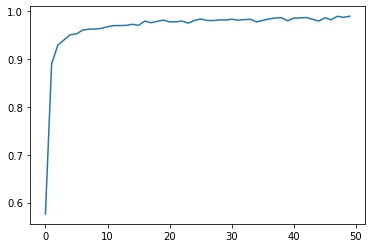

In [11]:
plt.plot(h.history['accuracy'])

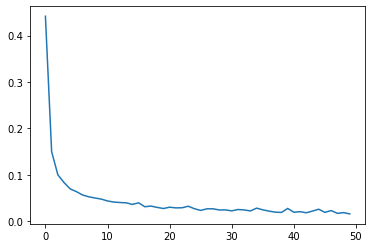

In [12]:
plt.plot(h.history['loss'])

In [16]:
X_test.shape

(2000, 6, 1)

In [20]:
n_test = X_test.shape[0]
n_test = batch_size * int(n_test / batch_size)

model.evaluate(X_test[:n_test], y_test[:n_test], batch_size=32)

62/62 [==============================] - 0s 4ms/step - loss: 0.0220 - accuracy: 0.9817


[0.02198924869298935, 0.9817206263542175]

In [21]:
X_test[:2]

array([[[ 1.       ],
        [ 0.4512195],
        [-1.       ],
        [-1.       ],
        [-1.       ],
        [-1.       ]],

       [[ 1.       ],
        [-1.       ],
        [-1.       ],
        [-1.       ],
        [-1.       ],
        [-1.       ]]], dtype=float32)

In [22]:
y_pred = model.predict(X_test[:-16])

In [23]:
y_pred_pos = y_pred.argmax(axis=2)
y_pred_idx = y_pred.argmax(axis=1)
y_pred_pos[:10] #, y_pred_idx[:2]

array([[2, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 2, 0, 0, 0, 0],
       [3, 2, 1, 0, 0, 0],
       [1, 2, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [3, 5, 2, 4, 1, 0],
       [2, 1, 0, 0, 0, 0],
       [1, 2, 0, 0, 0, 0]])

In [24]:
y_test_pos = y_test.argmax(axis=2)
y_test_idx = y_test.argmax(axis=1)
y_test_pos[:10] #, y_test_idx[:2]

array([[2, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 2, 0, 0, 0, 0],
       [3, 2, 1, 0, 0, 0],
       [1, 2, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [3, 5, 2, 4, 1, 0],
       [2, 1, 0, 0, 0, 0],
       [1, 2, 0, 0, 0, 0]])

In [38]:
X_ = X_test[:batch_size]
X_[0] = [[0.2], [1.0], [-1], [-1], [-1], [-1]]
X_[1] = [[1.0], [1.0], [1.0], [1.0], [1.0], [-1]]
X_[2] = [[1.0], [0.2], [0.1], [1.0], [0.8], [-1]]

X_[:3]

array([[[ 0.2],
        [ 1. ],
        [-1. ],
        [-1. ],
        [-1. ],
        [-1. ]],

       [[ 1. ],
        [ 1. ],
        [ 1. ],
        [ 1. ],
        [ 1. ],
        [-1. ]],

       [[ 1. ],
        [ 0.2],
        [ 0.1],
        [ 1. ],
        [ 0.8],
        [-1. ]]], dtype=float32)

In [39]:
y_pred = model.predict(X_)
y_pred_pos = y_pred.argmax(axis=2)
y_pred_idx = y_pred.argmax(axis=1)
y_pred_pos[:3]#, y_pred_idx[:3]

array([[1, 2, 0, 0, 0, 0],
       [5, 5, 2, 3, 3, 0],
       [3, 2, 5, 1, 4, 0]])

In [26]:
# _X = X_test[:2]
# m = masking(_X)
# e, h, c = encoder(m)
# K.sum( K.cast((e[:, -1] == h),  dtype=np.int32) ) / K.prod(h.shape)
# d = decoder(e, [h,c])
# d

In [40]:
# def compute_accuracy(_y_true, _y_pred):
#     acc = keras.metrics.Accuracy()
#     return acc(_y_true, _y_pred).numpy()

# print( compute_accuracy(y_pred_idx.argsort(), y_pred_pos) )
# print( compute_accuracy(y_test_idx.argsort(), y_test_pos) )
# print( compute_accuracy(y_pred_pos, y_test_pos[:-16]) )
# print( compute_accuracy(y_pred_idx, y_test_idx[:-16]) )